1. Setup Mario

In [5]:
!pip install gym_super_mario_bros nes_py

In [6]:
#import the game
import gym_super_mario_bros
#import the joypad wrapper
from nes_py.wrappers import JoypadSpace
#import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [7]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [9]:
#Create a flag - restart or not
done = True
#loop through each frame in the game
for step in range(1):
    #start the game to begin with
    if done:
        env.reset()
    #do random actions
    # action = env.action_space.sample()
    # print(action)
    state, reward, done, info = env.step(env.action_space.sample())
    #show the game on the screen
    env.render()
#close the game
env.close()

In [10]:
env.close()

ValueError: env has already been closed.

2. Preprocess Environment

In [17]:
#import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import FrameStack, GrayScaleObservation
#import Vectorization wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
#import matplot
from matplotlib import pyplot as plt

In [18]:
#1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
#3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
#4. wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
#5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [26]:
state = env.reset()

In [29]:
state, reward, done, info = env.step([5])

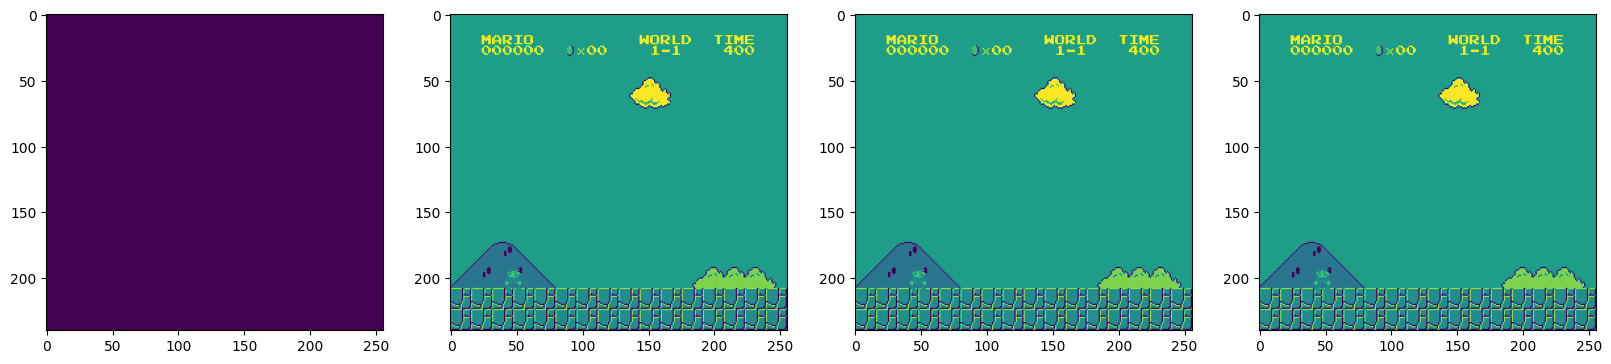

In [30]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

3. Train the RL Model

In [32]:
#import os for file path managment
import os
#import PPO for algos
from stable_baselines3 import PPO
#import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [33]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
            self.model.save(model_path)
        return True


In [34]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [35]:
# setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [36]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,
           n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [37]:
#train the agent
model.learn(total_timesteps=20000)

Logging to ./logs/PPO_1


C:\Users\elbou\anaconda3\envs\mlenv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 24  |
|    iterations      | 1   |
|    time_elapsed    | 21  |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 2            |
|    time_elapsed         | 37           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 5.344255e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.00178      |
|    learning_rate        | 1e-06        |
|    loss                 | 116          |
|    n_updates            | 10           |
|    policy_gradient_loss | 6.56e-05     |
|    value_loss           | 313          |
------------------------------------------
-----------------------

In [38]:
model.save("best_model_20000")

4. Test it Out

In [40]:
#load model
model = PPO.load('best_model_20000')

In [42]:
#start game
state = env.reset()
#loop through the game
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

C:\Users\elbou\anaconda3\envs\mlenv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 